In [4]:
import os 
import numpy as np
import torch
import torch.nn.functional as F
import cv2

# utils.py

In [5]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=False):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for input in inputs:
        input = pre_processing(input, cuda)
        output = model(input)
        output = F.softmax(output, dim=1)
        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()
        index = np.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor(index, dtype=torch.int64)
        if cuda:
            index = index.cuda()
        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx

def pre_processing(obs, cuda):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std
    obs = np.transpose(obs, (2, 0, 1))
    obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    if cuda:
        torch_device = torch.device('cuda:0')
    else:
        torch_device = torch.device('cpu')
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=torch_device, requires_grad=True)
    return obs_tensor

# # generate the entire images
# def generate_entrie_images(img_origin, img_grad, img_grad_overlay, img_integrad, img_integrad_overlay):
#     blank = np.ones((img_grad.shape[0], 10, 3), dtype=np.uint8) * 255
#     blank_hor = np.ones((10, 20 + img_grad.shape[0] * 3, 3), dtype=np.uint8) * 255
#     upper = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_grad_overlay, blank, img_grad], 1)
#     down = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_integrad_overlay, blank, img_integrad], 1)
#     total = np.concatenate([upper, blank_hor, down], 0)
#     total = cv2.resize(total, (550, 364))

#     return total


# generate the entire images
def generate_entrie_images(img_origin, img_grad, img_grad_overlay, img_integrad, img_integrad_overlay):
    blank = np.ones((img_grad.shape[0], 3, 3), dtype=np.uint8) * 255
    down = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_integrad_overlay, blank, img_integrad], 1)
    total = cv2.resize(down, (1008, 336))  # Resize the down image to its original size

    return total




# visualisation.py

In [6]:
G = [0, 255, 0]
R = [255, 0, 0]

def convert_to_gray_scale(attributions):
    return np.average(attributions, axis=2)

def linear_transform(attributions, clip_above_percentile=99.9, clip_below_percentile=70.0, low=0.2, plot_distribution=False):
    m = compute_threshold_by_top_percentage(attributions, percentage=100-clip_above_percentile, plot_distribution=plot_distribution)
    e = compute_threshold_by_top_percentage(attributions, percentage=100-clip_below_percentile, plot_distribution=plot_distribution)
    transformed = (1 - low) * (np.abs(attributions) - e) / (m - e) + low
    transformed *= np.sign(attributions)
    transformed *= (transformed >= low)
    transformed = np.clip(transformed, 0.0, 1.0)
    return transformed

def compute_threshold_by_top_percentage(attributions, percentage=60, plot_distribution=True):
    if percentage < 0 or percentage > 100:
        raise ValueError('percentage must be in [0, 100]')
    if percentage == 100:
        return np.min(attributions)
    flat_attributions = attributions.flatten()
    attribution_sum = np.sum(flat_attributions)
    sorted_attributions = np.sort(np.abs(flat_attributions))[::-1]
    cum_sum = 100.0 * np.cumsum(sorted_attributions) / attribution_sum
    threshold_idx = np.where(cum_sum >= percentage)[0][0]
    threshold = sorted_attributions[threshold_idx]
    if plot_distribution:
        raise NotImplementedError 
    return threshold

def polarity_function(attributions, polarity):
    if polarity == 'positive':
        return np.clip(attributions, 0, 1)
    elif polarity == 'negative':
        return np.clip(attributions, -1, 0)
    else:
        raise NotImplementedError

def overlay_function(attributions, image):
    return np.clip(0.7 * image + 0.5 * attributions, 0, 255)

def visualize(attributions, image, positive_channel=G, negative_channel=R, polarity='positive', \
                clip_above_percentile=99.9, clip_below_percentile=0, morphological_cleanup=False, \
                structure=np.ones((3, 3)), outlines=False, outlines_component_percentage=90, overlay=True, \
                mask_mode=False, plot_distribution=False):
    if polarity == 'both':
        raise NotImplementedError

    elif polarity == 'positive':
        attributions = polarity_function(attributions, polarity=polarity)
        channel = positive_channel
    
    # convert the attributions to the gray scale
    attributions = convert_to_gray_scale(attributions)
    attributions = linear_transform(attributions, clip_above_percentile, clip_below_percentile, 0.0, plot_distribution=plot_distribution)
    attributions_mask = attributions.copy()
    if morphological_cleanup:
        raise NotImplementedError
    if outlines:
        raise NotImplementedError
    attributions = np.expand_dims(attributions, 2) * channel
    if overlay:
        if mask_mode == False:
            attributions = overlay_function(attributions, image)
        else:
            attributions = np.expand_dims(attributions_mask, 2)
            attributions = np.clip(attributions * image, 0, 255)
            attributions = attributions[:, :, (2, 1, 0)]
    return attributions

# integrated_gradients.py

In [7]:
# integrated gradients
def integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, baseline, steps=50, cuda=False):
    if baseline is None:
        baseline = 0 * inputs 
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = predict_and_gradients(scaled_inputs, model, target_label_idx, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.transpose(avg_grads, (1, 2, 0))
    delta_X = (pre_processing(inputs, cuda) - pre_processing(baseline, cuda)).detach().squeeze(0).cpu().numpy()
    delta_X = np.transpose(delta_X, (1, 2, 0))
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, steps, num_random_trials, cuda):
    all_intgrads = []
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, \
                                                baseline=255.0 *np.random.random(inputs.shape), steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
        print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

# data.py

In [8]:
import torchvision.datasets as datasets
from torchvision import transforms

def generate_torch_dataset(
    dataset_name, # Which dataset to use 'cifar10', 'fashionmnist'
    val_size=0.2,
    transform=transforms.ToTensor(), # Convert image to tensor
    target_transform=None,
    debug=False,
    seed=42
):
    os.makedirs('./datasets', exist_ok=True)
    root = f'./datasets/{dataset_name}'

    if dataset_name=='cifar10':
        dataset_class = datasets.CIFAR10
    elif dataset_name=='fashionmnist':
        dataset_class = datasets.FashionMNIST
    

    train_dataset = dataset_class(
        root=root,
        train=True,
        transform=transform, 
        target_transform=target_transform,
        download=True
    )

    if isinstance(train_dataset.targets, list):
        num_classes = len(set(train_dataset.targets))
    else:
        num_classes = len(train_dataset.targets.unique())

    if debug:
        train_dataset = torch.utils.data.Subset(train_dataset, [x for x in range(100)])

    train_size = int((1-val_size) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size], generator=generator)

    test_dataset = dataset_class(
        root=root,
        train=False,
        transform=transform, 
        target_transform=target_transform,
        download=True
    )

    
    return train_dataset, val_dataset, test_dataset, num_classes


def fashionmnist_image_transform():
    transform = transforms.Compose([ 
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]) 
    return transform

def cifar10_image_transform():
    transform = transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]) 
    return transform

# model.py

In [9]:

import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import math
import torch.utils.model_zoo as model_zoo
from torchvision.ops import DeformConv2d


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=int(nr_steps))

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

class CBAM(nn.Module):

    def __init__(self, n_channels_in, reduction_ratio, kernel_size):
        super(CBAM, self).__init__()
        self.n_channels_in = n_channels_in
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size

        self.channel_attention = ChannelAttention(n_channels_in, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, f):
        chan_att = self.channel_attention(f)
        fp = chan_att * f
        spat_att = self.spatial_attention(fp)
        fpp = spat_att * fp
        return fpp


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        assert kernel_size % 2 == 1, "Odd kernel size required"
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size,
                              padding=int((kernel_size - 1) / 2))

    def forward(self, x):
        max_pool = self.agg_channel(x, "max")
        avg_pool = self.agg_channel(x, "avg")
        pool = torch.cat([max_pool, avg_pool], dim=1)
        conv = self.conv(pool)
        conv = conv.repeat(1, x.size()[1], 1, 1)
        att = torch.sigmoid(conv)
        return att

    def agg_channel(self, x, pool="max"):
        b, c, h, w = x.size()
        x = x.view(b, c, h * w)
        x = x.permute(0, 2, 1)
        if pool == "max":
            x = F.max_pool1d(x, int(c))
        elif pool == "avg":
            x = F.avg_pool1d(x, int(c))
        x = x.permute(0, 2, 1)
        x = x.view(b, 1, h, w)
        return x


class ChannelAttention(nn.Module):
    def __init__(self, n_channels_in, reduction_ratio):
        super(ChannelAttention, self).__init__()
        self.n_channels_in = n_channels_in
        self.reduction_ratio = reduction_ratio
        self.middle_layer_size = int(self.n_channels_in / float(self.reduction_ratio))

        self.bottleneck = nn.Sequential(
            nn.Linear(self.n_channels_in, self.middle_layer_size),
            nn.ReLU(),
            nn.Linear(self.middle_layer_size, self.n_channels_in)
        )

    def forward(self, x):
        kernel = (x.size()[2], x.size()[3])
        avg_pool = F.avg_pool2d(x, kernel)
        max_pool = F.max_pool2d(x, kernel)

        avg_pool = avg_pool.view(avg_pool.size()[0], -1)
        max_pool = max_pool.view(max_pool.size()[0], -1)

        avg_pool_bck = self.bottleneck(avg_pool)
        max_pool_bck = self.bottleneck(max_pool)

        pool_sum = avg_pool_bck + max_pool_bck

        sig_pool = torch.sigmoid(pool_sum)
        sig_pool = sig_pool.unsqueeze(2).unsqueeze(3)

        out = sig_pool.repeat(1, 1, kernel[0], kernel[1])
        return out


def constant_init(module, constant, bias=0):
    nn.init.constant_(module.weight, constant)
    if hasattr(module, 'bias'):
        nn.init.constant_(module.bias, bias)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# BasicBlock consists of two convolutional layers only used in resnet18,resnet34
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, cbam=False, dcn=False):
        super(BasicBlock, self).__init__()
        self.with_dcn = dcn
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        if not self.with_dcn:
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        else:
            # deformable_groups = dcn.get('deformable_groups', 1)
            deformable_groups = 1
            offset_channels = 18
            self.conv2_offset = nn.Conv2d(planes, deformable_groups * offset_channels, kernel_size=3, padding=1)
            self.conv2 = DeformConv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.use_cbam = cbam
        if self.use_cbam:
            self.cbam = CBAM(n_channels_in=self.expansion * planes, reduction_ratio=1, kernel_size=3)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if not self.with_dcn:
            out = self.conv2(out)
        else:
            offset = self.conv2_offset(out)
            out = self.conv2(out, offset)

        out = self.bn2(out)

        if self.use_cbam:
            out = self.cbam(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# Consists of three Convolutional Layers, used as building blocks in resnet50 & higher
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, cbam=False, dcn=False):
        super(Bottleneck, self).__init__()
        self.with_dcn = dcn
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Replace 3*3 normal conv2d with deformconv2d if dcn=True
        if not self.with_dcn:
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        else:
            # deformable_groups = dcn.get('deformable_groups', 1)
            deformable_groups = 1
            offset_channels = 18
            self.conv2_offset = nn.Conv2d(planes, deformable_groups * offset_channels, stride=stride, kernel_size=3, padding=1)
            self.conv2 = DeformConv2d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.use_cbam = cbam
        if self.use_cbam:
            self.cbam = CBAM(n_channels_in=self.expansion * planes, reduction_ratio=1, kernel_size=3)
        

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if not self.with_dcn:
            out = self.conv2(out)
        else:
            offset = self.conv2_offset(out)
            out = self.conv2(out, offset)

        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.use_cbam:
            out = self.cbam(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# added method to freeze all layers except the offset layers
class Resnet(nn.Module):

    def __init__(self, block, layers, num_classes, cbam=False, dcn=[0,0,0,0],unfreeze_conv=[0,0,0,0],unfreeze_offset=True,unfreeze_fc=True, drop_prob=0):
        super(Resnet, self).__init__()
        self.inplanes = 64
        self.dcn = dcn
        self.cbam = cbam
        self.drop = drop_prob != 0
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.out_channels = []
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        if self.drop:
            self.dropblock = LinearScheduler(
                DropBlock2D(drop_prob=drop_prob, block_size=5),
                start_value=0.,
                stop_value=drop_prob,
                nr_steps=5e3
            )
        self.layer1 = self._make_layer(block, 64, layers[0],dcn=dcn[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, cbam=self.cbam,dcn=dcn[1])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, cbam=self.cbam, dcn=dcn[2])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, cbam=self.cbam, dcn=dcn[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output_fc = nn.Linear(self.out_channels[2] * 2, num_classes)

        if self.dcn is not None:
            for m in self.modules():
                if isinstance(m, Bottleneck) or isinstance(m, BasicBlock):
                    if hasattr(m, 'conv2_offset'):
                        constant_init(m.conv2_offset, 0)

        self.out_shape = [self.out_channels[0] * 2,
                          self.out_channels[1] * 2,
                          self.out_channels[2] * 2]


        print("backbone output channel: C3 {}, C4 {}, C5 {}".format(self.out_channels[0] * 2, self.out_channels[1] * 2, self.out_channels[2] * 2))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
       

        self.freeze_all_layers()
        if unfreeze_offset:
            self.unfreeze_offset()
        if unfreeze_fc:
            self.unfreeze_fc()

        self.unfreeze_conv(unfreeze_conv)
    
    def freeze_all_layers(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def unfreeze_dcn(self):
        for module in self.modules():
            if isinstance(module, DeformConv2d):
                for param in module.parameters():
                    param.requires_grad = True
    
    def unfreeze_conv(self, last_layer):
        # Get the corresponding block
        for idx,num_layer in enumerate(last_layer):
            block = getattr(self, f'layer{idx+1}')
            if num_layer>0:
                # Freeze the 3x3 conv in the specified layers
                for layer in block[-num_layer:]:
                    layer.conv2.requires_grad = True           

    def unfreeze_offset(self):
        for name, param in self.named_parameters():
            if 'offset' in name:
                param.requires_grad = True
    
    def unfreeze_fc(self):
        for module in self.modules():
            if isinstance(module,nn.Linear):
                for param in module.parameters():
                    param.requires_grad = True

    def _make_layer(self, block, planes, blocks, stride=1, cbam=False, dcn=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        
        # True to set 3x3 conv to dcn
        dcns = ([False]*(blocks-dcn)) + ([True]*dcn)
        layers = [block(self.inplanes, planes, stride, downsample, cbam=cbam, dcn=dcns[0])]
        self.inplanes = planes * block.expansion
        self.out_channels.append(self.inplanes)

        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, cbam=cbam, dcn=dcns[i]))

        return nn.Sequential(*layers)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        if self.drop:
            x1 = self.dropblock(self.layer1(x))
            x2 = self.dropblock(self.layer2(x1))
        else:
            x1 = self.layer1(x)
            x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        xx4 = self.avgpool(x4)
        x = torch.flatten(x4, 1)
        x = self.output_fc(x)

        y = torch.softmax(x, dim=1)
        
        return y


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34'], model_dir='.'), strict=False)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50'], model_dir='.'), strict=False)
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101'], model_dir='.'), strict=False)
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = Resnet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152'], model_dir='.'), strict=False)
    return model


def resnet(pretrained=False, **kwargs):
    version = str(kwargs.pop('version'))
    if version == '18':
        return resnet18(pretrained, **kwargs)
    if version == '34':
        return resnet34(pretrained, **kwargs)
    if version == '50':
        return resnet50(pretrained, **kwargs)
    if version == '101':
        return resnet101(pretrained, **kwargs)
    if version == '152':
        return resnet152(pretrained, **kwargs)

In [10]:
kwargs = {'version':'152','unfreeze_conv':[0,0,9,3],'dcn':[0,0,9,3],'num_classes':10}
model = resnet(pretrained=True,**kwargs)

backbone output channel: C3 512, C4 1024, C5 2048


In [11]:
train_dataset,val_dataset,test_dataset,num_classes = generate_torch_dataset('fashionmnist',transform=fashionmnist_image_transform())

# main.py

In [36]:
def write_image_with_ig(model,best_weights_path,image_tensor,output_path,image_name,cuda=False):

    # check if have the space to save the results
    if not os.path.exists('results/'):
        os.mkdir('results/')
    if not os.path.exists('results/' + output_path[2:]):
        os.mkdir('results/' + output_path[2:])

    model.load_state_dict(torch.load(best_weights_path,map_location='cpu'))
    model.eval()
    if cuda:
        model.cuda()
    # read the image
    image_np = image_tensor.numpy()
    image_np = (image_np*255).astype(np.uint8)

    img = image_np.transpose(1, 2, 0)  # Change the order of the dimensions to (28, 28, 3)

    img = img.astype(np.float32)
     
    # img = img[:, :, (2, 1, 0)]

    # calculate the gradient and the label index
    gradients, label_index = calculate_outputs_and_gradients([img], model, None, cuda)
    gradients = np.transpose(gradients[0], (1, 2, 0))
    img_gradient_overlay = visualize(gradients, img, clip_above_percentile=99, clip_below_percentile=0, overlay=True, mask_mode=True)
    img_gradient = visualize(gradients, img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)

    # calculae the integrated gradients 
    attributions = random_baseline_integrated_gradients(img, model, label_index, calculate_outputs_and_gradients, \
                                                        steps=50, num_random_trials=50, cuda=cuda)
    img_integrated_gradient_overlay = visualize(attributions, img, clip_above_percentile=99, clip_below_percentile=0, \
                                                overlay=True, mask_mode=True)
    img_integrated_gradient = visualize(attributions, img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)
    output_img = generate_entrie_images(img, img_gradient, img_gradient_overlay, img_integrated_gradient, \
                                        img_integrated_gradient_overlay)

    # change image name manually
    # image_name = 'trials_50_fashion_image_100_0.jpg'
    cv2.imwrite(f"results/{output_path[2:]}/{image_name}_trials_50.jpg", np.uint8(output_img))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


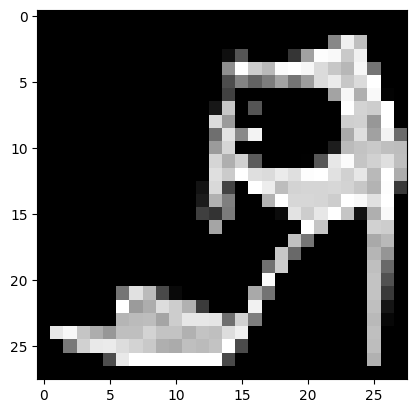

In [37]:
import matplotlib.pyplot as plt

# Convert the tensor to a numpy array
image_np = train_dataset[100][0].numpy()

# If the image is grayscale and has shape (1, 28, 28), remove the first dimension
if image_np.shape[0] == 1:
    image_np = image_np[0]

# If the image has shape (3, 28, 28), change the order of the dimensions to (28, 28, 3)
if image_np.shape[0] == 3:
    image_np = image_np.transpose(1, 2, 0)

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')
plt.show()


In [38]:
import json

In [39]:
# resnet_152_deformable_cifar10_20231106_1850
# resnet_152_deformable_fashionmnist_20231106_1615
with open ('./resnet_152_deformable_fashionmnist_20231106_1615/experiment_details.json','r')as f:
    file = json.load(f)
output_dir = file['output_dir']
for i in range(0,48000,1000):
    write_image_with_ig(model,'./resnet_152_deformable_fashionmnist_20231106_1615/best_weights.pth',train_dataset[i][0],image_name=f"image{i}",output_path=output_dir)

the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
the trial number is: 5
the trial number is: 6
the trial number is: 7
the trial number is: 8
the trial number is: 9
the trial number is: 10
the trial number is: 11
the trial number is: 12
the trial number is: 13
the trial number is: 14
the trial number is: 15
the trial number is: 16
the trial number is: 17
the trial number is: 18
the trial number is: 19
the trial number is: 20
the trial number is: 21
the trial number is: 22
the trial number is: 23
the trial number is: 24
the trial number is: 25
the trial number is: 26
the trial number is: 27
the trial number is: 28
the trial number is: 29
the trial number is: 30
the trial number is: 31
the trial number is: 32
the trial number is: 33
the trial number is: 34
the trial number is: 35
the trial number is: 36
the trial number is: 37
the trial number is: 38
the trial number is: 39
the trial number is: 40
the trial number is: 41
th

In [ ]:
from alibi.explainers import IntegratedGradients
from alibi.datasets import fetch_imagenet
import torch
import torchvision.models as models

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)
resnet.eval()

# Load the Imagenet dataset
_, X_test, _, _ = fetch_imagenet()

# Create an instance of the IntegratedGradients explainer
explainer = IntegratedGradients(resnet, n_steps=50)

# Compute the Integrated Gradients for an image in the dataset
ig = explainer.explain(X_test[0])
# Get the Integrated Gradients for each feature
ig_values = ig.attributions


In [ ]:
ig_values_normalized = (ig_values - ig_values.min()) / (ig_values.max() - ig_values.min())
ig_values_display = np.squeeze(np.transpose(ig_values_normalized, (1, 2, 0)))
import matplotlib.pyplot as plt

# Display the original image
plt.imshow(X_test[0])

# Overlay the heatmap on the original image
plt.imshow(ig_values_display, alpha=0.5, cmap='jet')

# Display the plot
plt.show()
